### Setup & Imports

In [20]:
# Data handling
import pandas as pd
import numpy as np
import yaml
import joblib
import time
import matplotlib.pyplot as plt

# Models
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import lightgbm as lgb
import xgboost as xgb

# MLflow
import mlflow
import mlflow.sklearn

# Warnings
import warnings
warnings.filterwarnings("ignore")

### Load Config

In [2]:
# Load YAML config
with open("../../configs/training.yml", "r") as f:
    config = yaml.safe_load(f)

print(config)

{'models': [{'name': 'lightgbm', 'type': 'lightgbm', 'max_depth': 7, 'learning_rate': 0.05, 'n_estimators': 500}, {'name': 'xgboost', 'type': 'xgboost', 'max_depth': 7, 'learning_rate': 0.05, 'n_estimators': 500}], 'metrics': {'primary': 'roc_auc', 'secondary': 'f1_score'}, 'thresholds': {'risk_flag': 0.7}, 'hyperparameter_search': {'method': 'gridsearch', 'lightgbm': {'num_leaves': [31, 50, 70], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 300, 500]}, 'xgboost': {'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 300, 500]}}, 'logging': {'experiment': 'dropout_prediction', 'tool': 'mlflow'}}


### Load Preprocessed Data

In [3]:
X_train = pd.read_csv("../../data/processed/X_train.csv")
y_train = pd.read_csv("../../data/processed/y_train.csv").values.ravel()
X_val = pd.read_csv("../../data/processed/X_val.csv")
y_val = pd.read_csv("../../data/processed/y_val.csv").values.ravel()

print("Train shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)

Train shape: (3539, 36) (3539,)
Validation shape: (442, 36) (442,)


### Define Models & Hyperparameters

In [ ]:
# LightGBM
lgb_config = next(m for m in config['models'] if m['type'] == 'lightgbm')
lgb_model = lgb.LGBMClassifier(
    max_depth=lgb_config['max_depth'],
    learning_rate=lgb_config['learning_rate'],
    n_estimators=lgb_config['n_estimators']
)
lgb_params = config['hyperparameter_search']['lightgbm']

In [5]:
# XGBoost
xgb_config = next(m for m in config['models'] if m['type'] == 'xgboost')
xgb_model = xgb.XGBClassifier(
    max_depth=xgb_config['max_depth'],
    learning_rate=xgb_config['learning_rate'],
    n_estimators=xgb_config['n_estimators'],
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb_params = config['hyperparameter_search']['xgboost']

### Initialize MLflow

In [6]:
mlflow.set_experiment(config['logging']['experiment'])

<Experiment: artifact_location='file:///d:/Student_ropout_risk/src/models/mlruns/818261885524770619', creation_time=1759731522755, experiment_id='818261885524770619', last_update_time=1759731522755, lifecycle_stage='active', name='dropout_prediction', tags={}>

### Train and Log LightGBM

In [22]:
with mlflow.start_run(run_name="LightGBM"):
    start = time.time()
    
    # GridSearchCV for hyperparameter tuning
    lgb_grid = GridSearchCV(lgb_model, lgb_params, cv=5, scoring='roc_auc', n_jobs=-1) # type: ignore
    lgb_grid.fit(X_train, y_train)
    
    # Predict on validation
    y_val_pred = lgb_grid.predict(X_val)
    y_val_proba = lgb_grid.predict_proba(X_val)[:,1]
    
    # Metrics
    roc_auc = roc_auc_score(y_val, lgb_grid.predict_proba(X_val), multi_class='ovr')
    f1 = f1_score(y_val, y_val_pred, average='macro')
    auc = accuracy_score(y_val, y_val_pred)
    end = time.time()
    
    # Log
    mlflow.log_params(lgb_grid.best_params_)
    mlflow.log_metric("roc_auc", roc_auc) # type: ignore
    mlflow.log_metric("f1_score", f1) # type: ignore
    mlflow.log_metric("train_time_sec", end-start)
    mlflow.sklearn.log_model(lgb_grid.best_estimator_, "model") # type: ignore
    
    print(f"LightGBM - ROC AUC: {roc_auc:.4f}, F1: {f1:.4f}, auc : {auc:.4}")

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002267 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1049
[LightGBM] [Info] Number of data points in the train set: 3539, number of used features: 36
[LightGBM] [Info] Start training from score -1.135451
[LightGBM] [Info] Start training from score -1.717974
[LightGBM] [Info] Start training from score -0.694561


2025/10/07 09:26:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 09:26:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


LightGBM - ROC AUC: 0.8839, F1: 0.6304, auc : 0.7466


### Train and Log XGBoost

In [23]:
with mlflow.start_run(run_name="XGBoost"):
    start = time.time()
    
    # GridSearchCV for hyperparameter tuning
    xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='roc_auc', n_jobs=-1)
    xgb_grid.fit(X_train, y_train)
    
    # Predict on validation
    y_val_pred = xgb_grid.predict(X_val)
    y_val_proba = xgb_grid.predict_proba(X_val)[:,1]
    
    # Metrics
    roc_auc = roc_auc_score(y_val, xgb_grid.predict_proba(X_val), multi_class='ovr')
    f1 = f1_score(y_val, y_val_pred, average='macro')
    auc = accuracy_score(y_val, y_val_pred)
    end = time.time()
    
    # Log
    mlflow.log_params(xgb_grid.best_params_)
    mlflow.log_metric("roc_auc", roc_auc) # type: ignore
    mlflow.log_metric("f1_score", f1) # type: ignore
    mlflow.log_metric("train_time_sec", end-start)
    mlflow.sklearn.log_model(xgb_grid.best_estimator_, "model") # type: ignore
    
    print(f"XGBoost - ROC AUC: {roc_auc:.4f}, F1: {f1:.4f}, auc : {auc:.4}")


2025/10/07 09:29:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 09:29:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


XGBoost - ROC AUC: 0.8636, F1: 0.6695, auc : 0.7647


### Compare Models & Select Best|

In [ ]:
# Example: Compare ROC-AUC on validation
results = {
    "LightGBM": roc_auc_score(y_val, lgb_grid.predict_proba(X_val), multi_class='ovr'),
    "XGBoost": roc_auc_score(y_val, xgb_grid.predict_proba(X_val), multi_class='ovr')
}

best_model_name = max(results, key=results.get    ) # type: ignore
best_model = lgb_grid.best_estimator_ if best_model_name=="LightGBM" else xgb_grid.best_estimator_

print(f"Best Model: {best_model_name} with ROC-AUC = {results[best_model_name]:.4f}")

# Save best model
joblib.dump(best_model, "../../models/best_model.pkl")

Best Model: LightGBM with ROC-AUC = 0.8839


['../../models/best_model.pkl']

### Learning Curve

In [25]:
# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve( # type: ignore
    xgb_grid, X_train, y_train,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

KeyboardInterrupt: 

In [ ]:
# Compute mean and std
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1) 

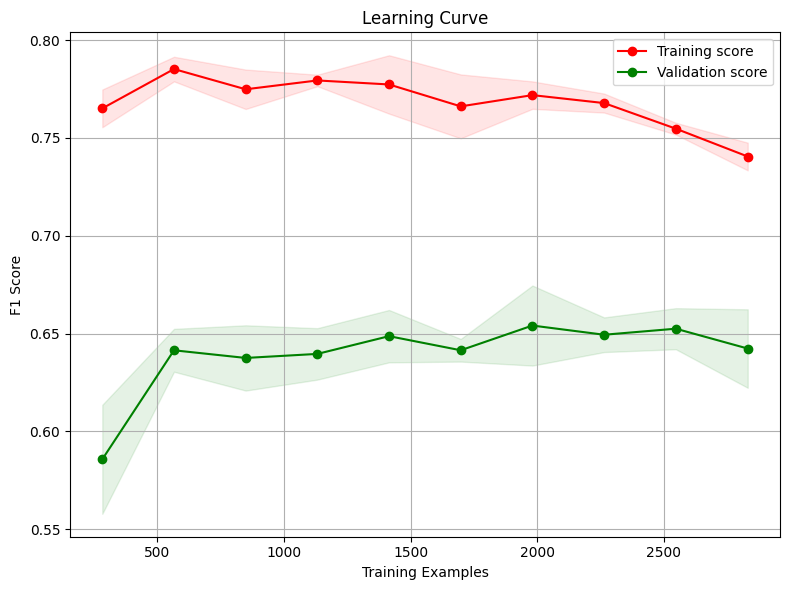

In [18]:
# Plot
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_mean, 'o-', color="g", label="Validation score")
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, color="r", alpha=0.1)
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, color="g", alpha=0.1)
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("F1 Score")
plt.legend(loc="best")
plt.grid(True)
plt.tight_layout()
plt.savefig("../../reports/learning_curve.png", bbox_inches="tight")
plt.show()

In [32]:
X_test = pd.read_csv("../../data/processed/X_test.csv")
y_test = pd.read_csv("../../data/processed/y_test.csv").values.ravel()
best_model1 = joblib.load("../../models/best_model.pkl")
y_test_pred = best_model1.predict(X_test) # type: ignore

auc = accuracy_score(y_test_pred, y_test)
auc

0.7697516930022573